In [1]:
import os
import pickle
import shutil
import re
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

from konlpy.tag import Kkma

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
USE_CUDA = torch.cuda.is_available()
#USE_CUDA = False
GPU_ID = 2

# 1. Preprocess Dataset

In [3]:
SOS_IDX = 0
EOS_IDX = 1

MAX_LENGTH = 15 + 1

In [4]:
class Data:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_IDX: "<s>", EOS_IDX: "</s>"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
SRC_FILENAME = 'dataset/korean_humor/korean_humor_source.txt'
TGT_FILENAME = 'dataset/korean_humor/korean_humor_target.txt'

In [6]:
def normalizeString(s):
    #s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [7]:
def readData(src_fileName, tgt_fileName, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    src_lines = open(src_fileName, 'r', encoding='utf-8').readlines()
    tgt_lines = open(tgt_fileName, 'r', encoding='utf-8').readlines()
    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(src_lines[i][:-1]), normalizeString(tgt_lines[i][:-1])] for i in range(len(src_lines))]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_data = Data()
        output_data = Data()
    else:
        input_data = Data()
        output_data = Data()

    print("Success!")
    
    return input_data, output_data, pairs

In [8]:
def filterPair(p):
    return len(p[0]) < MAX_LENGTH and \
        len(p[1]) < MAX_LENGTH

def filterPairs(pairs):
    tagger = Kkma()
    pairs = [[tagger.morphs(pair[0]), tagger.morphs(pair[1])] for pair in pairs]
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(src_fileName, tgt_fileName, reverse=False):
    input_data, output_data, pairs = readData(src_fileName, tgt_fileName)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_data.addSentence(pair[0])
        output_data.addSentence(pair[1])
    print("Counted words :")
    print("- Input data  :", input_data.n_words)
    print("- Output data :", output_data.n_words)
    
    return input_data, output_data, pairs

In [10]:
input_data, output_data, pairs = prepareData(SRC_FILENAME, TGT_FILENAME)
random.choice(pairs)

Reading lines...
Success!
Read 2483 sentence pairs
Trimmed to 1946 sentence pairs
Counting words...
Counted words :
- Input data  : 1483
- Output data : 948


[['네이버', '최고'], ['질투심', '유발', '작전', '이', 'ㄴ가요', '?']]

In [11]:
train_data = [d for d in pairs[:10000]]
test_data = [d for d in pairs[:1000]]
dev_data = [d for d in pairs[:1000]]

In [12]:
def indexesFromSentence(data, sentence):
    return [data.word2index[word] for word in sentence]

In [13]:
def variableFromSentence(data, sentence):
    indexes = indexesFromSentence(data, sentence)
    indexes.append(EOS_IDX)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if USE_CUDA:
        return result.cuda(GPU_ID)
    else:
        return result

In [14]:
def variablesFromPair(pair):
    input_variable = variableFromSentence(input_data, pair[0])
    target_variable = variableFromSentence(output_data, pair[1])
    return (input_variable, target_variable)

# 3. Define Model

In [15]:
INPUT_SIZE = input_data.n_words  # Num of Words
HIDDEN_SIZE = 50  # Embedding Dimension
OUTPUT_SIZE = output_data.n_words

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if USE_CUDA:
            return result.cuda(GPU_ID)
        else:
            return result

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if USE_CUDA:
            return result.cuda(GPU_ID)
        else:
            return result

In [18]:
teacher_forcing_ratio = 0.5

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda(GPU_ID) if USE_CUDA else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        #print(ei, input_variable[ei], encoder_output.size())
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_IDX]]))
    decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_IDX:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [19]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [20]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [21]:
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [22]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [23]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_data, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda(GPU_ID) if USE_CUDA else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_IDX]]))  # SOS
    decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_IDX:
            decoded_words.append('</s>')
            break
        else:
            decoded_words.append(output_data.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

    return decoded_words

In [24]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [25]:
NUM_ITER = 250000

In [26]:
encoder = EncoderRNN(INPUT_SIZE, HIDDEN_SIZE)
decoder = DecoderRNN(HIDDEN_SIZE, OUTPUT_SIZE)
if USE_CUDA:
    encoder.cuda(GPU_ID)
    decoder.cuda(GPU_ID)

12m 38s (- 113m 49s) (25000 10%) 3.5455
27m 23s (- 109m 32s) (50000 20%) 2.6541
40m 52s (- 95m 21s) (75000 30%) 2.1817
53m 20s (- 80m 0s) (100000 40%) 1.7460
66m 22s (- 66m 22s) (125000 50%) 1.5427
78m 2s (- 52m 1s) (150000 60%) 1.3358
90m 27s (- 38m 46s) (175000 70%) 1.4700
104m 56s (- 26m 14s) (200000 80%) 1.5182
118m 16s (- 13m 8s) (225000 90%) 1.9289
131m 39s (- 0m 0s) (250000 100%) 2.0625


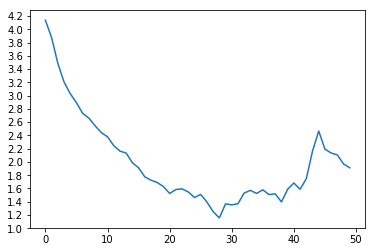

In [27]:
trainIters(encoder, decoder, NUM_ITER, print_every=NUM_ITER/10, plot_every=NUM_ITER/100, learning_rate=1e-2)

In [28]:
evaluateRandomly(encoder, decoder)

> ['혹시', '아빠', '이름', '좀', '알리', '어', '주', 'ㄹ래', '?']
= ['아빠', '이름', '은', '토', '니', '에', '요']
< 아빠 이름 은 토 니 에 요 </s>

> ['너', '진짜', '안', '되', '겠', '구나']
= ['혹시', '때리', '시', '는', '건', '아니', '겠', '죠', '.', '.', '?', 'ㅠㅠ']
< 저희 아버지 불르 어 드리 어요 ! </s>

> ['나', 'vs', '너', '둘', '중', '누', '가', '똘똘', '하', 'ㄹ까', '?']
= ['솔직', '하', '게', '말하', '면', '되', '는', '것', '이', 'ㄴ가요', '?']
< 생각 지도 못하 ㄴ 질문 이 ㄴ데요 ? </s>

> ['선호', '하', '는', '영화배우', '가', '있', '다면', '?']
= ['김', '혜', '수', '!', '너무', '멋있', '고', '매력적', '이', '야']
< 힙합 ! 내 가 좀 힙 하 거든 ! </s>

> ['어이']
= ['아', '담', '이', '라고', '불르', '어', '주', '어요', '~']
< 그렇 게 대화 끝내 지 마 요 ~ </s>

> ['SNS', 'ID', '계정', '알려주', '어']
= ['아이디', '가', '없', '는걸요', '.', '.']
< 전 언니 가 안되 어요 . . </s>

> ['너', '여동생', '있', '어', '?']
= ['알', '뇨', ',', '저', '는', '여동생', '이', '없', '답니다', '.']
< 그럼 요 ~ 저 도 이 ? </s>

> ['전공', '과목', '이', '어떻', '게', '되', '어', '?']
= ['저', '는', '학교', '에', '다니', '지', '않', '아서', '전공', '분야', '가', '없', '어요', '.']
< 전 지식 의 우주 에서 공부 하 어요 </s>

> ['너', '가', '어디', '